# Visualization of Utah COVID-19 Cases for 2020

Inspriation for these visualizations came from [Matt Harrison's](https://www.linkedin.com/in/panela/) daily COVID-19 plots that he began publishing on LinkedIn during the spring of 2020.

In [13]:
%matplotlib inline

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Let me see all columns

In [15]:
pd.options.display.max_columns = 999

This is required to eliminate a pandas deprecation warning related to implicit datetime conversions.

In [16]:
pd.plotting.register_matplotlib_converters()

Raw data location on Github

In [17]:
url = ('https://github.com/COVID19Tracking/covid-tracking-data/'
       'raw/master/data/states_daily_4pm_et.csv')

In [18]:
df = pd.read_csv(url, parse_dates=['date', 'dateChecked'])

In [19]:
df[df['state'] == 'UT'].head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
48,2020-04-15,UT,2542.0,45072.0,NaN,NaN,221.0,NaN,NaN,NaN,NaN,218.0,f1de11bfb56f8f39c4440f1921363b342a5826da,2020-04-15 20:00:00+00:00,20.0,221.0,47614.0,47614.0,47614.0,49,1.0,8.0,1008.0,130.0,1138.0
104,2020-04-14,UT,2412.0,44064.0,NaN,NaN,213.0,NaN,NaN,NaN,NaN,218.0,b371027ae74241bec0dac952659857e3af0b88d7,2020-04-14 20:00:00+00:00,19.0,213.0,46476.0,46476.0,46476.0,49,1.0,12.0,640.0,49.0,689.0
160,2020-04-13,UT,2363.0,43424.0,NaN,NaN,201.0,NaN,NaN,NaN,NaN,218.0,9da0e13ad75b4e608cac7956fda03bd19ba2d526,2020-04-13 20:00:00+00:00,18.0,201.0,45787.0,45787.0,45787.0,49,0.0,6.0,1493.0,60.0,1553.0
216,2020-04-12,UT,2303.0,41931.0,NaN,NaN,195.0,NaN,NaN,NaN,NaN,NaN,2ed0a5b83fb1172a55311e320b688ef899102994,2020-04-12 20:00:00+00:00,18.0,195.0,44234.0,44234.0,44234.0,49,0.0,5.0,1591.0,97.0,1688.0
272,2020-04-11,UT,2206.0,40340.0,NaN,NaN,190.0,NaN,NaN,NaN,NaN,NaN,aed7ede8563fb5e0601845af9649cc018e08d406,2020-04-11 20:00:00+00:00,18.0,190.0,42546.0,42546.0,42546.0,49,1.0,7.0,1680.0,104.0,1784.0


In [20]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
formatter = mdates.ConciseDateFormatter(days)

In [21]:
sns.set(context='talk', palette='deep', color_codes=True, style='darkgrid')

## Matt Harrison's Original Plot

With some added `seaborn` styling....

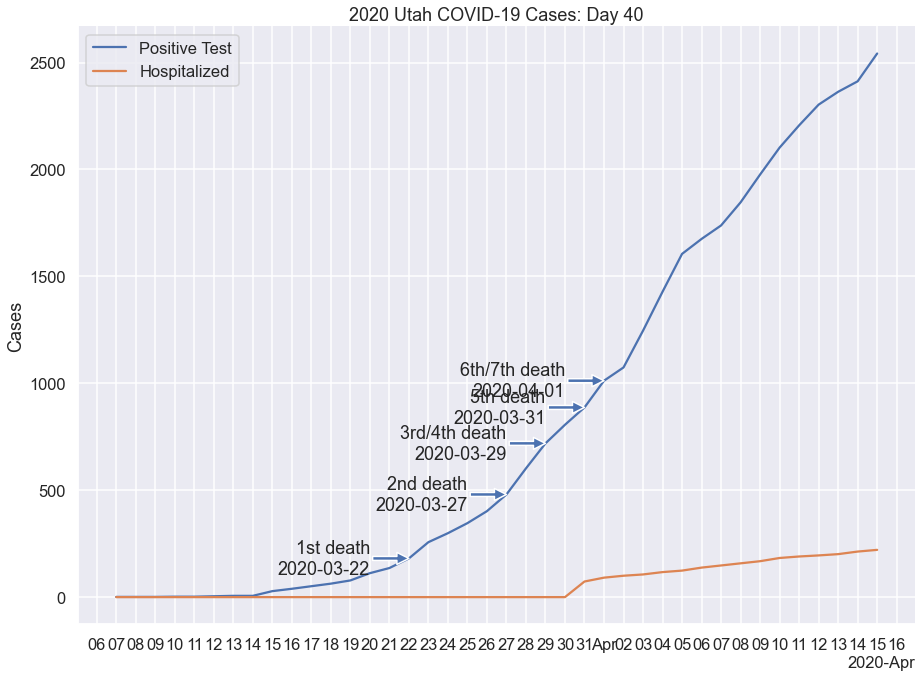

In [22]:
with sns.plotting_context('talk'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death']]
            .fillna(0)
           )
    fig, ax = plt.subplots(figsize=(15, 11))
    ax.plot(data.positive, label='Positive Test')
    ax.plot(data.hospitalized, label='Hospitalized')
    ax.set_ylabel('Cases')
    ax.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')

    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    deaths = [
        ('1st', pd.Timestamp('2020-03-22')),
        ('2nd', pd.Timestamp('2020-03-27')),
        ('3rd/4th', pd.Timestamp('2020-03-29')),
        ('5th', pd.Timestamp('2020-03-31')),
        ('6th/7th', pd.Timestamp('2020-04-01'))
    ]
    
    for num, date in deaths:
        val = data.loc[date, 'positive']
        ax.annotate(f'{num} death\n{date.strftime("%Y-%m-%d")}',
                    xy=(date, val),
                    xytext=(date - pd.DateOffset(days=2), val),
                    arrowprops={},
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    sns.despine()
    ax.legend(loc='upper left')

## Break Out Subplots

How does it look if we break everything out into subplots instead?

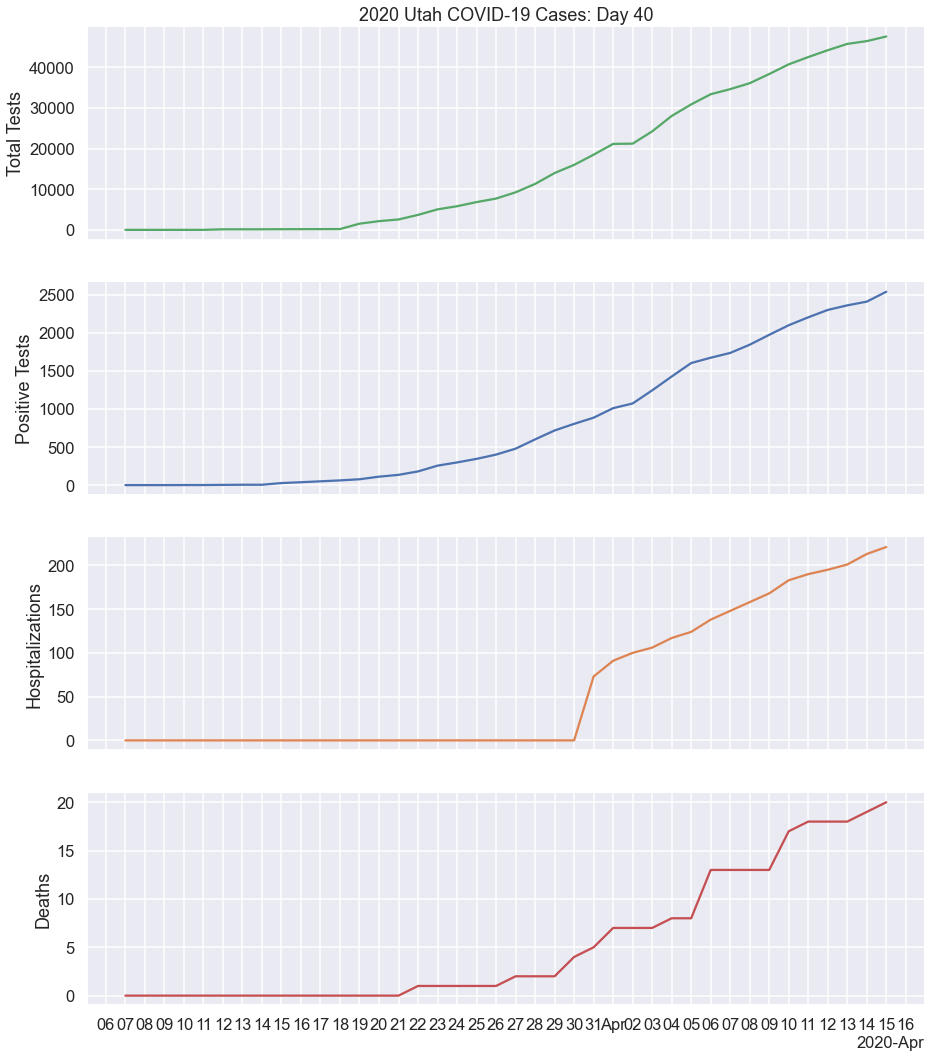

In [23]:
with sns.plotting_context('talk'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
            .fillna(0)
           )
    fig, ax = plt.subplots(4, 1, figsize=(15, 18), sharex=True)
 
    ax[0].plot(data.totalTestResults, color='C2', label='Total Tests')
    ax[0].set_ylabel('Total Tests')
    ax[0].set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    
    ax[1].plot(data.positive, color='C0', label='Positive Test')
    ax[1].set_ylabel('Positive Tests')
    
    ax[2].plot(data.hospitalized, color='C1', label='Hospitalized')
    ax[2].set_ylabel('Hospitalizations')
    
    ax[3].plot(data.death, color='C3', label='Deaths')
    ax[3].set_ylabel('Deaths')

    ax[0].xaxis.set_major_locator(days)
    ax[0].xaxis.set_major_formatter(formatter)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=0)
    
    sns.despine()

## Multiple Y-Axes on Single Plot

The subplots indicate similar curve shapes. Let's express them on a common plot with multiple y axes. Additionally, let's ignore the missing hospitalization data rather than fill it with zeros.

Inspiration for the multiple axes technique comes from the [Multiple Yaxis Wtih Spines](https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html) example on the matplotlib site.

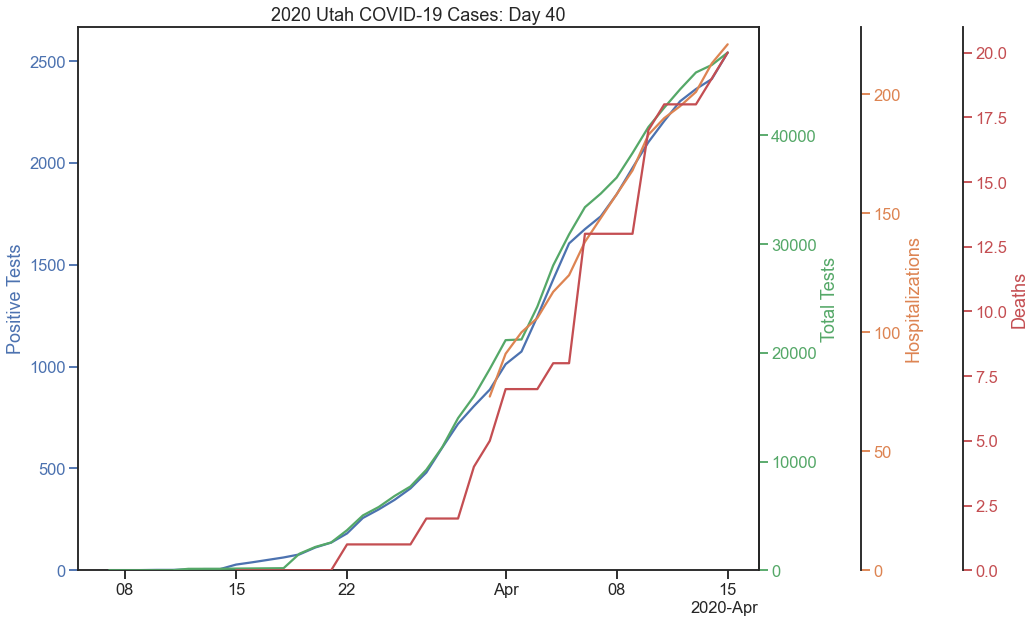

In [24]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

with sns.axes_style('ticks'):
    data = (df
            [df.state == 'UT']
            .set_index('date')
            [['positive', 'hospitalized', 'death', 'totalTestResults']]
#             .fillna(0)
           )
    fig, ax_0 = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
    fig.subplots_adjust(right=0.65)

    ax_1 = ax_0.twinx()
    ax_2 = ax_0.twinx()
    ax_3 = ax_0.twinx()

    ax_2.spines['right'].set_position(('axes', 1.15))
    ax_3.spines['right'].set_position(('axes', 1.3))

    make_patch_spines_invisible(ax_1)
    make_patch_spines_invisible(ax_2)
    make_patch_spines_invisible(ax_3)

    ax_1.spines['right'].set_visible(True)
    ax_2.spines['right'].set_visible(True)
    ax_3.spines['right'].set_visible(True)

    tick_kws = dict()

    line_0, = ax_0.plot(data.positive, color='C0', label='Positive Test')
    ax_0.set_ylabel('Positive Tests')
    ax_0.set_title(f'2020 Utah COVID-19 Cases: Day {data.shape[0]}')
    ax_0.yaxis.label.set_color(line_0.get_color())
    ax_0.set_ylim(bottom=0.0)
    ax_0.tick_params(axis='y', colors=line_0.get_color(), **tick_kws)

    line_1, = ax_1.plot(data.totalTestResults, color='C2', label='Total Tests')
    ax_1.set_ylabel('Total Tests')
    ax_1.yaxis.label.set_color(line_1.get_color())
    ax_1.set_ylim(bottom=0.0)
    ax_1.tick_params(axis='y', colors=line_1.get_color(), **tick_kws)

    line_2, = ax_2.plot(data.hospitalized, color='C1', label='Hospitalized')
    ax_2.set_ylabel('Hospitalizations')
    ax_2.yaxis.label.set_color(line_2.get_color())
    ax_2.set_ylim(bottom=0.0)
    ax_2.tick_params(axis='y', colors=line_2.get_color(), **tick_kws)

    line_3, = ax_3.plot(data.death, color='C3', label='Deaths')
    ax_3.set_ylabel('Deaths')
    ax_3.yaxis.label.set_color(line_3.get_color())
    ax_3.set_ylim(bottom=0.0)
    ax_3.tick_params(axis='y', colors=line_3.get_color(), **tick_kws)

#     ax_0.xaxis.set_major_locator(days)
    ax_0.xaxis.set_major_formatter(formatter)
    plt.setp(ax_0.xaxis.get_majorticklabels(), rotation=0)

fig.savefig('covid_multiple_y_axes.png', dpi=300, bbox_inches='tight')
#     sns.despine()